In [1]:
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

In [3]:
#first: data processing: (careful she takes a long time)
path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'

tree_pipm = ur.open(path_pipm)['EventTree']
tree_pi0  = ur.open(path_pi0)['EventTree']

geoDict_tree_pipm = ur.open(path_pipm)['CellGeo']
geoDict_tree_pi0  = ur.open(path_pi0)["CellGeo"]

cell_id_pipm = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pipm, 2000)
cell_e_pipm = gu.loadArrayBranchFlat('cluster_cell_E', tree_pipm, 2000)
cell_id_pi0 = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pi0, 2000)
cell_e_pi0 = gu.loadArrayBranchFlat('cluster_cell_E', tree_pi0, 2000)

geoDict_pipm = gu.loadGraphDictionary(geoDict_tree_pipm)
geoDict_pi0  = gu.loadGraphDictionary(geoDict_tree_pi0)

cell_phi_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_phi', geoDict_pipm)
cell_eta_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_eta', geoDict_pipm)
cell_phi_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_phi', geoDict_pi0)
cell_eta_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_eta', geoDict_pi0)

clus_eta_pipm = gu.loadVectorBranchFlat('cluster_Eta', tree_pipm)
clus_E_pipm = gu.loadVectorBranchFlat('cluster_E', tree_pipm)

clus_eta_pi0 = gu.loadVectorBranchFlat('cluster_Eta', tree_pi0)
clus_E_pi0 = gu.loadVectorBranchFlat('cluster_E', tree_pi0)

clus_phi_pipm = gu.loadVectorBranchFlat('cluster_Phi', tree_pipm)
clus_phi_pi0  = gu.loadVectorBranchFlat('cluster_Phi', tree_pi0)

In [4]:
#HERE: change the eta cuts!
eta_mask_pipm = abs(clus_eta_pipm) < .5 #(abs(clus_eta_pipm) > 2.5) & (abs(clus_eta_pipm) < 3.1)
eta_mask_pi0  = abs(clus_eta_pi0) < .5 #(abs(clus_eta_pi0) > 2.5) & (abs(clus_eta_pi0) < 3.1)

energy_mask_pipm = clus_E_pipm > 0.5
energy_mask_pi0 = clus_E_pi0 > 0.5

selection_pipm = eta_mask_pipm & energy_mask_pipm
selection_pi0 = eta_mask_pi0 & energy_mask_pi0

eta_mask_pipm[:10], clus_eta_pipm[:10] #okay good that works jeez lol

(array([False, False, False, False, False,  True,  True,  True,  True,
        False]),
 array([-1.125384  , -0.9594247 ,  0.93537796, -1.9522849 ,  1.1632881 ,
        -0.06523713, -0.05172568, -0.09848271, -0.03274849,  1.0723295 ],
       dtype=float32))

In [5]:
#dont rerun
cell_eta_norm_pipm = np.nan_to_num(cell_eta_pipm - clus_eta_pipm[:, None])
cell_eta_norm_pi0 = np.nan_to_num(cell_eta_pi0 - clus_eta_pi0[:, None])
cell_phi_norm_pipm = np.nan_to_num(cell_phi_pipm - clus_phi_pipm[:, None])
cell_phi_norm_pi0 = np.nan_to_num(cell_phi_pi0 - clus_phi_pi0[:, None])

cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)

# Working after some careful manipulation of the masks
cell_samp_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_sampling', geoDict_pipm)
cell_samp_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_sampling', geoDict_pi0)

#normalize to a lower value fairly arbitrarily
cell_samp_norm_pipm = cell_samp_pipm * 0.1
cell_samp_norm_pi0 = cell_samp_pi0 * 0.1


<ipython-input-5-9ca06993e40d>:7: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
<ipython-input-5-9ca06993e40d>:8: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)


In [7]:
#rerun!!!
X_pipm = np.stack((cell_e_norm_pipm[selection_pipm], cell_eta_norm_pipm[selection_pipm], cell_phi_norm_pipm[selection_pipm], cell_samp_norm_pipm[selection_pipm]), axis = 2)
X_pi0  = np.stack((cell_e_norm_pi0[selection_pi0], cell_eta_norm_pi0[selection_pi0], cell_phi_norm_pi0[selection_pi0], cell_samp_norm_pi0[selection_pi0]), axis = 2)

len(X_pipm), len(X_pi0)

(85061, 66266)

In [ ]:
#rerun with appropriate size! 
X = np.concatenate((X_pipm[:65000], X_pi0[:65000]))
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(65000), np.zeros(65000)))) #one hot
len(X, Y)

Now onto the pfn

In [6]:
#first with the .7 cut
#X = np.load(data_path+'X_4.npy')
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000)))) #one hot
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

# do train/val/test split 
(X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

#make the model:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [7]:
# train model
history = pfn.fit(X_train, Y_train, epochs=100, batch_size=500, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/100
260/260 [==============================] - 28s 89ms/step - loss: 14.5482 - acc: 0.6897 - val_loss: 0.6330 - val_acc: 0.7112
Epoch 2/100
260/260 [==============================] - 14s 55ms/step - loss: 0.8271 - acc: 0.7431 - val_loss: 0.4829 - val_acc: 0.6966
Epoch 3/100
260/260 [==============================] - 15s 57ms/step - loss: 0.5281 - acc: 0.7549 - val_loss: 0.4397 - val_acc: 0.7500
Epoch 4/100
260/260 [==============================] - 15s 58ms/step - loss: 0.4503 - acc: 0.7737 - val_loss: 0.4380 - val_acc: 0.7891
Epoch 5/100
260/260 [==============================] - 15s 56ms/step - loss: 0.4533 - acc: 0.7788 - val_loss: 0.4027 - val_acc: 0.7955
Epoch 6/100
260/260 [==============================] - 14s 55ms/step - loss: 0.4274 - acc: 0.7925 - val_loss: 0.3730 - val_acc: 0.8157
Epoch 7/100
260/260 [==============================] - 15s 58ms/step - loss: 0.3667 - acc: 0.8390 - val_loss: 0.3250 - val_acc: 0.8773
Epoch 8/100
260/260 [==============================] -

In [8]:
preds = pfn.predict(X_test, batch_size=1000)

In [9]:
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

In [10]:
# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.9786282785868711



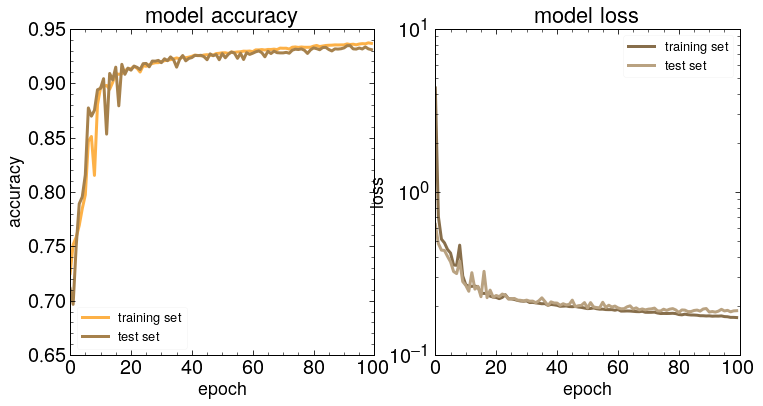

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
ax1.set_xlim(0,100)
ax1.plot(history.history['acc'], label='training set', c='xkcd:butterscotch', linewidth=3)
ax1.plot(history.history['val_acc'], label='test set', c='xkcd:coffee', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.set_xlim(0,100)
ax2.plot(history.history['loss'], label='training set', c='xkcd:dull brown', linewidth=3)
ax2.plot(history.history['val_loss'], label='test set', c='xkcd:taupe', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')
ax2.legend()

In [48]:
def modelNmetrics(X):
    #X = np.load(data_path+'X_4.npy')
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print(len(X), len(Y))
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

    #make the model:
    pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

    # train model
    history = pfn.fit(X_train, Y_train, epochs=100, batch_size=500, validation_data=(X_val, Y_val), verbose=1)
    
    preds = pfn.predict(X_test, batch_size=1000)
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print('PFN AUC:', auc)

    return history

In [26]:
# for eta between 0.7 and 1.5:
history_btw = modelNmetrics(X)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [28]:
def plots(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,100)
    ax1.plot(history.history['acc'], label='training set', c='xkcd:butterscotch', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:coffee', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,100)
    ax2.plot(history.history['loss'], label='training set', c='xkcd:dull brown', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:taupe', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()

PFN AUC: 0.963399424854064
for .7 < $\eta$ < 1.5


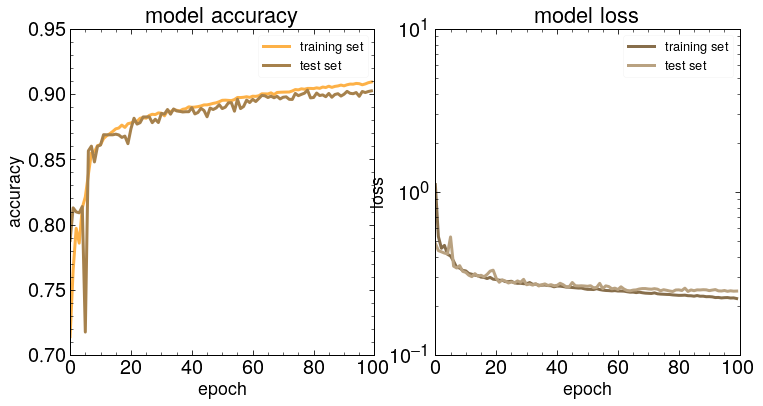

In [30]:
plots(history_btw)

In [33]:
# for eta greater than 1.5:
history_g15 = modelNmetrics(X)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

PFN AUC: 0.9481434457387163
for $\eta$ < 1.5


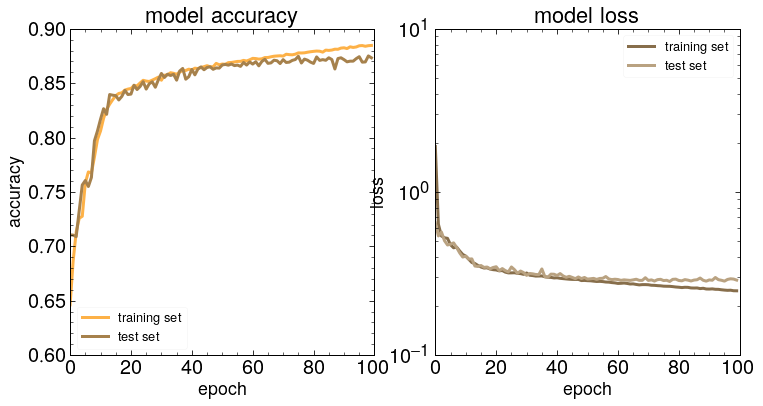

In [35]:
plots(history_g15)

In [39]:
# for all eta :  this does not do better than eta < .7
history_all = modelNmetrics(X)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
____________________________________________________________________________________________

PFN AUC: 0.9540910954777584
all eta


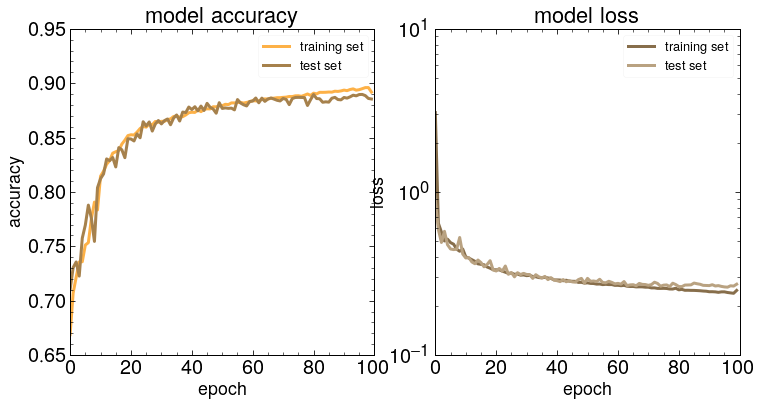

In [41]:
plots(history_all)

In [24]:
# for eta < 1.5
history_l15 = modelNmetrics(X)#not better than <.7

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

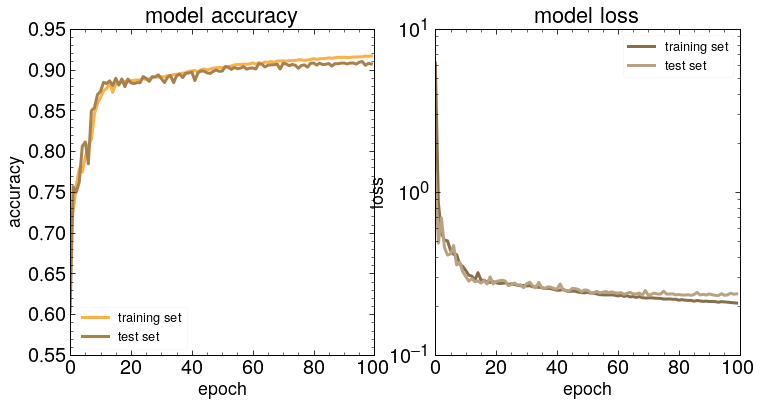

In [29]:
plots(history_l15)

In [32]:
history_l1 = modelNmetrics(X) #for eta less than 1

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
____________________________________________________________________________________________

In [39]:
history_l1[0], history_l15

(<tensorflow.python.keras.callbacks.History at 0x7f60395c3220>,
 <tensorflow.python.keras.callbacks.History at 0x7f5afc7abb20>)

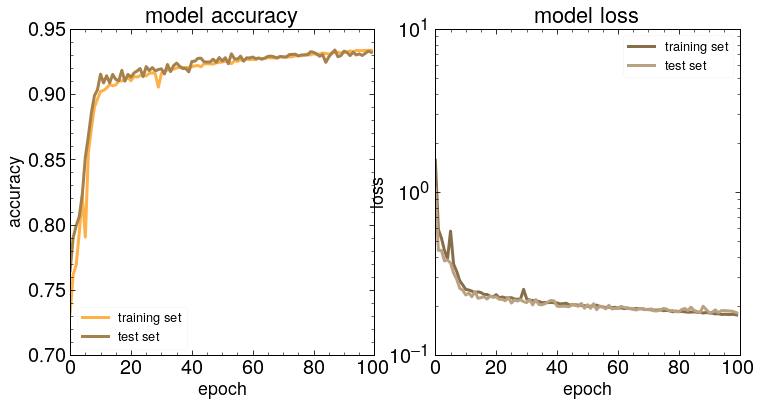

In [40]:
plots(history_l1[0])

In [55]:
history_l05 = modelNmetrics(X) #less than .5... doesn't work. because of the padding I think? what's up here??


151327 180000


AssertionError: args to data_split have different length

In [ ]:
plots(history_l05)

In [58]:
#also try: 0-1.4, 1.4-2.5, 2.5-3.1, 3.1+ bc these are the different detector sections I think based on that graphic

#1.4 - 2.5

history_1425 = modelNmetrics(X)

180000 180000
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_35 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_35[0][0]              
______________________________________________________________________________

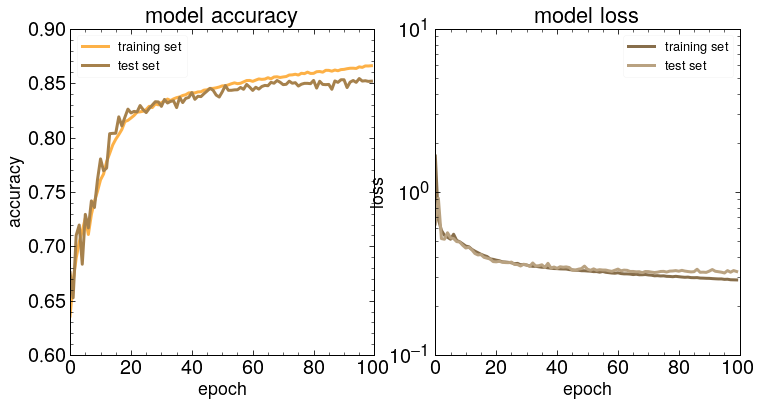

In [60]:
plots(history_1425)

In [63]:
history_2531 = modelNmetrics(X) #uh oh this one wont work either probably 3.1+ wont either

75652 180000


AssertionError: args to data_split have different length

In [ ]:
plots(history_2531)

In [67]:
history_l06 = modelNmetrics(X)#okay dang

169590 180000


AssertionError: args to data_split have different length

In [ ]:
plots(history_l06)